# High Frequency Finance 

### Part I: Trading Strategy 
***

Implementing a trading strategy for the FX (Foreign Exchange) market based on the intrinsic time framework first requires implementing a dissection algorithm, which will dissect the FX prices into a collection of intrinsic events. The dissection algorithm dissects the FX prices using a threshold $\delta$. At the first tick, the algorithm sets the tick price equal to the local extrema and records this as an IE (intrinsic event). 



At the next tick price, we compare the current tick price to the local extrema and set the mode to either "up" (tick price greater than local extrema) or "down" (tick price less than local extrema). 



Once we have the initial mode of the dissection algorithm, we then use an iterative process between alternating modes when a directional change is observed, which is when the difference between the local extrema and tick price is greater than or equal to the threshold $\delta$. The algorithm dissects using the threshold and we can observe when there is an IE or DC (directional change). The algorithm returns 1 and -1 when the FX price reaches an upward or downwards trend and returns 2 and -2 when there is an overshoot intrinsic event.



This dissection algorithm is implemented, also an extension to the algorithm is added to record the extremes. The extremes are only observed once the next directional change in the opposite mode is reached. The extrema are the maximum price between the upward directional change and downward directional change when a downward directional change is observed, also the minimum point between the upward directional change and downward directional change when an upward directional change is observed.



**Libraries required:**

Libraries required for implementation are:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Dissection algorithm:**

Below is the implemented dissection algorithm which will be used by the trading strategy. The algorithm is programmed in OOP (Object Orientated Programming) to allow easier implementation of the trading strategy as well as to make the code more structured for scalability and observations. An assumption made in terms of the FX price is that it is equal to the **Ask**, another assumption that can be made it can be the mid-point between the bid-ask spread, but as we are mostly interested in the implementation of the algorithm and the trading strategy will assume the FX pair price is equal to the **Ask**.

In [2]:
# Class created for dissection algorithm
class DissectionAlgo():
    # Define initial attributes
    def __init__(self,delta_up,delta_down,asset):
        # delta thresholds
        self.delta_up = delta_up
        self.delta_down = delta_down
        # FX data frame containing fx data
        self.asset = asset
        # List to store indexes of DC used for computing extremes
        self.DCs = list()
        # Records current event used for strategy and records all events
        self.event = int()
        self.events = list()
        # Class attribute used for defining mode 
        self.mode = ""
        # Record current dateTime of tick data
        self.tick_time = ""
        # List to record extremes
        self.extremes = list()

    # Method to get current tick price
    def price(self,i):
        return(self.asset['Ask'][i])

    # Mehtod to compute initial mode 
    def initialMode(self,i):
        if self.price(i) > self.price(i-1):
            self.mode = 'up'
        else:
            self.mode = 'down'

    # Method to compute extreme when DC is observed
    def updateExtrema(self,UD,i):
        # Condition when first DC is observed 
        if len(self.DCs) == 0:
            self.DCs = self.DCs
        # Condition for if DC is up/downwards 
        elif UD == 'U' or 'D':
            # Get index of previous DC
            previous = self.DCs[-1]
            # Condition if DC is equal to extrema
            if ((previous+1) == (i-1) or previous == i-1):
                    extrema = self.asset.loc[previous]['Ask']
                    indx = previous
                    combo = (indx,extrema)
                    self.extremes.append(combo)
            # Condition for upwards DC
            elif UD == "U":
                previous = self.DCs[-1]
                current_df = self.asset.loc[(previous+1):(i-1)]
                extrema = current_df['Ask'].min()
                indx = current_df['Ask'].idxmin()
                combo = (indx,extrema)
                self.extremes.append(combo)
            # Condition for downwards DC
            elif UD == "D":
                current_df = self.asset.loc[(previous+1):(i-1)]
                extrema = current_df['Ask'].max()
                indx = current_df['Ask'].idxmax()
                combo = (indx,extrema)
                self.extremes.append(combo)
    
    # Method to run dissection algorithm
    def algo(self,i):
        # Get current tick price using method
        self.S_tick = self.price(i)
        # Condition if first tick
        if i == 0:
            self.S_ext = self.S_tick
            self.S_ie = self.S_tick
            self.event = 0 
            self.extremes.append((i,self.S_tick))
            self.events.append(0)
        # Condition for next tick to set initial mode
        elif i == 1:
            self.initialMode(i)
            print(f"Initial mode is:", self.mode)

        # Condition when mode is up
        if self.mode == 'up':
            if (self.S_tick - self.S_ext) >= (self.delta_up):
                self.mode = 'down'
                self.S_ext = self.S_tick
                self.S_ie = self.S_tick
                self.updateExtrema("U",i)
                self.DCs.append(i)
                self.event = 1 
                self.events.append(1)
                
            elif self.S_tick < self.S_ext:
                self.S_ext = self.S_tick 
                if self.S_ie - self.S_ext >= (self.delta_down):
                    self.S_ie = self.S_tick
                    self.event = -2
                    self.events.append(-2)
                else:
                    self.event = 0
                    self.events.append(0)
            else:
                self.event = 0
                self.events.append(0)

        # Condition when mode is down
        # Condition if mode is up   
        elif self.mode == 'down':
            if (self.S_ext - self.S_tick) >= (self.delta_down):
                self.mode = 'up'
                self.S_ext = self.S_tick
                self.S_ie = self.S_tick
                self.updateExtrema("D",i)
                self.DCs.append(i)
                self.event = -1
                self.events.append(-1)
                
            elif self.S_tick > self.S_ext:
                self.S_ext = self.S_tick 
                if self.S_ext - self.S_ie >= (self.delta_up):
                    self.S_ie = self.S_tick
                    self.event = 2
                    self.events.append(2)
                else:
                    self.event = 0
                    self.events.append(0)
                    
            else:
                self.event = 0
                self.events.append(0)
        # Get current tick date time
        self.time =  self.asset['DateTime'][i] 

Once the dissection algorithm has been implemented the next step is to test it. The algorithm should correctly identify the DC, OV and extremes of the FX price data. For initial implementation, we will use the FX tick data for the pair "EURGBP" from 01/06/2016.

Initial mode is: up


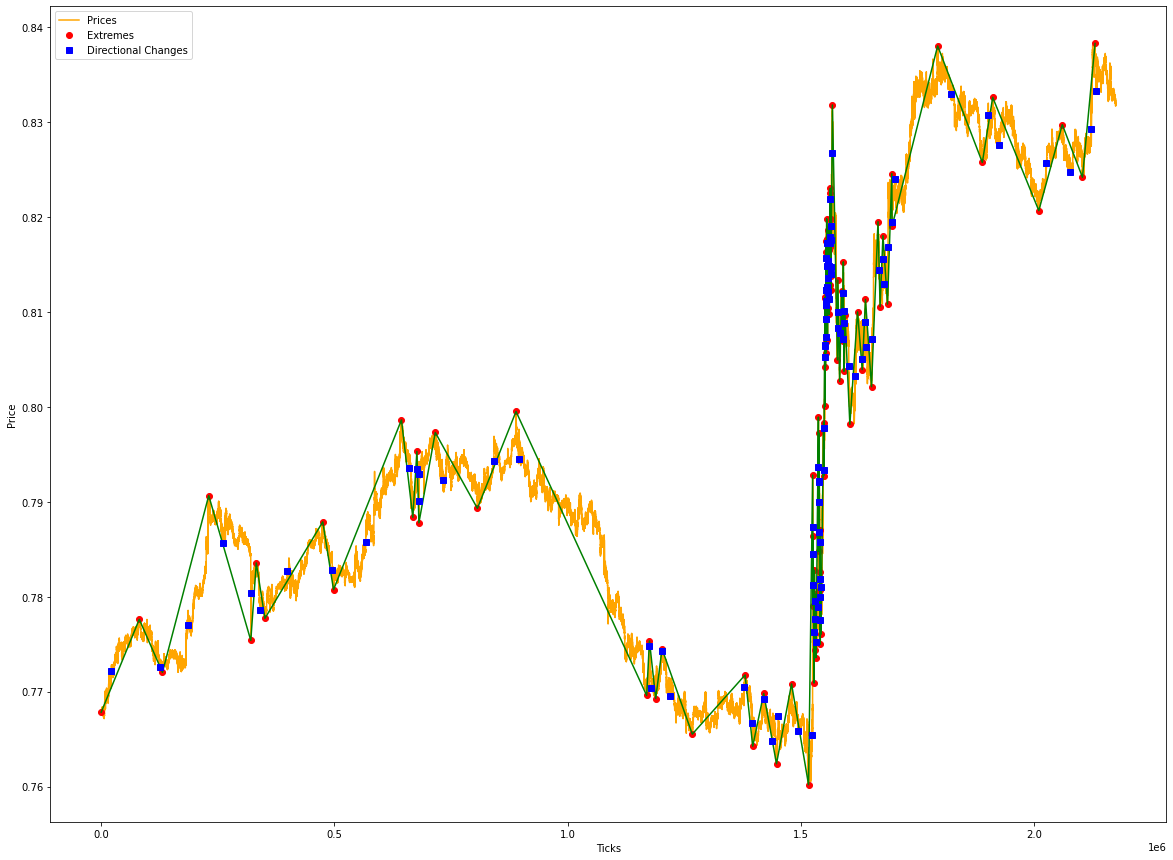

In [3]:
# Import FX tickdata
# Enter relative part to CSV file
EURGBP2016 = pd.read_csv(r"DAT_ASCII_EURGBP_T_201606.csv",header=None)
EURGBP2016 = EURGBP2016.rename(columns={0:"DateTime",1:'Bid',2:'Ask',3:'Volume'})

# Create object of dissection algorithm class
# Delta up and delta down are equal to 0.005 (0.5%)
al = DissectionAlgo(0.005,0.005,EURGBP2016)

# Run algo for length of prices in data
for i in range(len(EURGBP2016)):
    # dissection algorithm is run for each tick price
    al.algo(i)

# DC, OV list of events
DC = list()
OV = list()
# Separates overshoots and DC from the list that stores events
for i in range(len(al.events)):
    if al.events[i] == 1 or al.events[i] == -1:
        DC.append(EURGBP2016['Ask'][i])
    if al.events[i] == 2 or al.events[i] == -2:
        OV.append(EURGBP2016['Ask'][i])
    else:
        DC.append(None)
        OV.append(None)

# Plot dissection results for observation/testing
figure, axs = plt.subplots(figsize = (20,15))
plt.xlabel("Ticks")
plt.ylabel("Price")
plt.plot(EURGBP2016['Ask'],'orange',label = "Prices")

extremes_array = np.array(al.extremes)
transposed = extremes_array.T
timesEXT,valuesEXT = transposed
plt.plot(timesEXT,valuesEXT,"ro",label  = "Extremes")
plt.plot(timesEXT,valuesEXT,"g-")

plt.plot(DC,'bs',label = "Directional Changes")
plt.legend()
plt.show()

From observing the graph, we can observe that the dissection algorithm is functioning correctly. We can observe the extremes at the peaks and throughs of the varying price. Also, each DC happens only after passing the extreme by the threshold $\delta$. Having tested the algorithm the next step is to implement the trading strategy.

**Trading Strategy:**

The strategy implemented is a variant of the strategy covered in the lab. The strategy implemented is the following:

1. Open long position at DC $\uparrow (\theta)$ confirmation 
2. (Take profit:) Close position at $P_C \ge P_{DCC\uparrow} \times (1+\theta/ \rho_{profit})$
3. (Stop loss:) Close position at $P_C \le P_{DCC\uparrow} \times (1-\theta/ \rho_{loss})$

*We initially set $\rho_{profit}$ and $\rho_{loss}$ to 2, which indicates close position will be at $1 \pm$ (half the threshold $\delta$), depending if it is stop loss or take profit*

This strategy follows the pseudocode:
***


if (position is not open) and (current event is upwards DC)

$\quad$ position $\leftarrow$ open

$\quad$ $P_{DCC}$ $\leftarrow$ tick price

$\quad$  PnL = PnL - $P_{DCC}$

$\quad$  Take profit $\leftarrow$ ($P_{DCC}$ * (1 + theta/$\rho_{profit}$)

$\quad$  Stop Loss $\leftarrow$ ($P_{DCC}$ * (1 - theta/$\rho_{loss}$)

elif (position is open) and (tick price $\ge$ Take profit)

$\quad$  position $\leftarrow$ closed

$\quad$ PnL = PnL + tick price

elif (position is open) and (tick price $\le$ Stop Loss)

$\quad$ position $\leftarrow$ closed

$\quad$ PnL = PnL + tick price

***










Following the pseudocode, we can implement this strategy in Python. The code is implemented by using the dissection algorithm class to dissect the prices than using an iterative process to simulate tick data we apply the trading strategy. Using a function will allow us to implement a more structured testing procedure when doing backtesting. In addition, to the strategy during backtesting, we will vary the take profit and stop loss factors and observe the impact of varying these factors on the performance of the trading strategy. (initial stop loss factor and take profit factor equal to 2.)

`tradingStrategy()` function is used with arguments (dataset,delta,delta_up,delta_down,stop_loss_factor,take_profit_factor). Pass arguments to simulate strategy and make sure to run the class dissection algorithm form previous. 

In [4]:
# Define parameters
delta = 0.005
delta_up = delta
delta_down = delta
# Decide factor for stop loss #rho profit
stop_loss_factor = 2
# Decide factor for stop loss #rho loss
take_profit_factor = 2

def tradingStrategy(dataset,delta,delta_up,delta_down,stop_loss_factor,take_profit_factor):

    # Assigning initial position
    position_condition = "Initial"
    PnL = 0
    PnLs = list()
    number_of_trades = 0 

    al = DissectionAlgo(delta_up,delta_down,dataset)
    # Run algo for range of tick data for simulation
    for i in range(len(dataset)):
        # Run iteration of algo 
        al.algo(i)
        # Current price is equal to tick price
        Pc = al.S_tick
        # If upwards DC is observed and position is not open
        if (al.event == 1)  and (position_condition != "open"):
            # Open position and make trade
            number_of_trades += 1
            position_condition = 'open'
            # Price at upwards DCC is equal to current price
            P_DCC = Pc
            PnL -= P_DCC
            # Compute take profit and stop loss positions using factors
            Close_profit = (P_DCC * (1 + delta/take_profit_factor))
            Close_loss = P_DCC * (1 - delta/stop_loss_factor)
            #print("Position opened at:",al.time,"Price: ",P_DCC)

        elif (position_condition == "open") and (Pc >= Close_profit):
            position_condition = 'closed'
            PnL += Pc
            PnLs.append(Pc - P_DCC)
            #print(f"BUY: {P_DCC} SELL: {Pc} THRESHOLD {Close_profit}\n")

        elif (position_condition == "open") and (Pc <= Close_loss):
            position_condition = 'closed'
            PnL += Pc
            PnLs.append(Pc - P_DCC)
            #print(f"BUY: {P_DCC} SELL: {Pc} THRESHOLD {Close_loss}\n")
    
    return(PnL,number_of_trades)


# Run strategy strategy using function

PnL, number_of_trades = tradingStrategy(EURGBP2016,delta,delta_up,delta_down,stop_loss_factor,take_profit_factor)

print("PnL: ",PnL)
print(f"Number of trades {number_of_trades}")


Initial mode is: up
PnL:  0.0012599999999999278
Number of trades 50


### Part II: Testing your strategy
***

To backtest the implemented strategy, we will use different datasets which include the following FX tick data:

- EURGBP - 2016/06

- EURUSD - 2019/12

- EURCHF - 2022/04

We will test the strategy on the different FX data sets as well as vary the threshold to observe the strategy's effectiveness when the threshold changes and change the stop loss / take profit factors which determine where we close our position. This first requires importing the datasets and the data being stored as a pandas DataFrame.


In [5]:
# ADD relative path to csv file for importing

# Import EURGBP 2016 data set
EURGBP2016 = pd.read_csv(r"Coursework 2\DAT_ASCII_EURGBP_T_201606.csv",header=None)
EURGBP2016 = EURGBP2016.rename(columns={0:"DateTime",1:'Bid',2:'Ask',3:'Volume'})
# Import EURUSD 2019 data set
EURUSD2019 = pd.read_csv(r"Coursework 2\DAT_ASCII_EURUSD_T_201912.csv",header=None)
EURUSD2019 = EURUSD2019.rename(columns={0:"DateTime",1:'Bid',2:'Ask',3:'Volume'})
# Import EURCHF 2022 data set
EURCHF2022= pd.read_csv(r"Coursework 2\DAT_ASCII_EURCHF_T_202204.csv",header=None)
EURCHF2022 = EURCHF2022.rename(columns={0:"DateTime",1:'Bid',2:'Ask',3:'Volume'})

# Datasets
Datasets = [EURGBP2016,EURUSD2019,EURCHF2022]

# Observe data in data set if data requires cleaning
for Dataset in Datasets:
    print(Dataset.head())

             DateTime      Bid      Ask  Volume
0  20160601 000001687  0.76777  0.76784       0
1  20160601 000003937  0.76777  0.76785       0
2  20160601 000007937  0.76776  0.76784       0
3  20160601 000020937  0.76778  0.76786       0
4  20160601 000021687  0.76777  0.76785       0
             DateTime      Bid      Ask  Volume
0  20191201 170003296  1.10229  1.10247       0
1  20191201 170004413  1.10232  1.10247       0
2  20191201 170005270  1.10229  1.10247       0
3  20191201 170006063  1.10228  1.10246       0
4  20191201 170006629  1.10226  1.10244       0
             DateTime      Bid      Ask  Volume
0  20220401 000000099  1.02325  1.02339       0
1  20220401 000000201  1.02325  1.02337       0
2  20220401 000000303  1.02324  1.02337       0
3  20220401 000001453  1.02325  1.02337       0
4  20220401 000001656  1.02324  1.02337       0


Once we have our data sets imported the next stage is to apply the trading strategy to each data set. To test the strategy in these different data sets we will iterate through each data set and store the PnL (profit and loss), as well as the number of trades.

Having simulated trading using the different FX data we can view the PnL of each strategy to observe performance as well as the number of trades to indicate how many trades have been done at an upwards directional change. An assumption made for the trading strategy first is that only one unit of currency is traded on an upwards directional change, which we can observe by the low PnL of all datasets. Observing the empirical results we can depict that the number of trades made varies between the datasets. In terms of intrinsic events, this shows the "EURUSD" and "EURCHF" do not encounter a high amount of upwards directional changes, which can be due to upwards price change being less than $\delta_{up}$. Therefore, to modify the trading strategy we will decrease the $\delta$ so that more trades are exhibited in these two datasets. The use of gradient descent can be used to find a delta that will produce a high number of trades, whilst for this exercise, we assume a lower value through empirical testing.

In [6]:
# Create dictionary to store back testing results
back_testing_results = {"EURGBP":[],"EURUSD":[],"EURCHF":[]}

# Set delta up and delta down
delta = 0.005
delta_up = delta
delta_down = delta
stop_loss_factor = 2
take_profit_factor = 2

# Iterate through each FX dataset
for i in range(len(Datasets)):
    currentDataset = list(back_testing_results.keys())[i]
    print("Current dataset:", currentDataset)
    # Run strategy strategy using function
    PnL, number_of_trades = tradingStrategy(Datasets[i],delta,delta_up,delta_down,stop_loss_factor,take_profit_factor)
    print("Pnl",PnL,"Num of trades",number_of_trades,"\n")
    back_testing_results[list(back_testing_results.keys())[i]] = (PnL,number_of_trades)

Current dataset: EURGBP
Initial mode is: up
Pnl 0.0012599999999999278 Num of trades 50 

Current dataset: EURUSD
Initial mode is: down
Pnl 0.005639999999999867 Num of trades 4 

Current dataset: EURCHF
Initial mode is: down
Pnl -0.0051000000000001044 Num of trades 2 



We update $\delta$ from 0.5% to 0.1% and run the same simulation with all other parameters being constant, ceteris paribus. From the results, we can observe the increase in the intrinsic events in terms of upward directional changes observed with a small change in the threshold $\delta$. Although we increase the number of trades made due to the increase of a number of upward directional changes, the performance in terms of the profits decreases, shown by the profits below. 

In [7]:
# Create dictionary to store back testing results
back_testing_results_updateDelta = {"EURGBP":[],"EURUSD":[],"EURCHF":[]}

# Updated DELTA
delta = 0.001
delta_up = delta
delta_down = delta
stop_loss_factor = 2
take_profit_factor = 2

# Iterate through each FX dataset
for i in range(len(Datasets)):
    currentDataset = list(back_testing_results_updateDelta.keys())[i]
    print("Current dataset:", currentDataset)
    # Run strategy strategy using function
    PnL, number_of_trades = tradingStrategy(Datasets[i],delta,delta_up,delta_down,stop_loss_factor,take_profit_factor)
    print("Pnl",PnL,"Num of trades",number_of_trades,"\n")
    back_testing_results_updateDelta[list(back_testing_results_updateDelta.keys())[i]] = (PnL,number_of_trades)

Current dataset: EURGBP
Initial mode is: up


As we have observed a decrease in performance, we modify the trading strategy by varying the factors that control the take profit and stop-loss positions. We can increase the position of the take profit position by decreasing the take profit factor (in simulation decrease the factor from 2 to 1) as it is inversely proportional. We will keep the stop loss position constant.

From the results, below we can observe that the number of trades observed is not impacted by the change in the take profit factor. For the EURGBP data, we can see an increase in profit whilst for the other datasets our PnL decreased by a small amount. Further modification in the future would require observing scaling laws between the different data sets, by recording ticks between extrema and DC, also ticks between DC and overshoot. Using these ticks we can observe scaling laws which are fundamental for a good trading strategy. 

In [ ]:
# Create dictionary to store back testing results
back_testing_results_updatetakeprofit = {"EURGBP":[],"EURUSD":[],"EURCHF":[]}

# Updated DELTA - from previous simulation
delta = 0.001
delta_up = delta
delta_down = delta
stop_loss_factor = 2
# update take profit factor
take_profit_factor = 1

# Iterate through each FX dataset
for i in range(len(Datasets)):
    currentDataset = list(back_testing_results_updatetakeprofit.keys())[i]
    print("Current dataset:", currentDataset)
    # Run strategy strategy using function
    PnL, number_of_trades = tradingStrategy(Datasets[i],delta,delta_up,delta_down,stop_loss_factor,take_profit_factor)
    print("Pnl",PnL,"Num of trades",number_of_trades,"\n")
    back_testing_results_updatetakeprofit[list(back_testing_results_updatetakeprofit.keys())[i]] = (PnL,number_of_trades)

Current dataset: EURGBP
Initial mode is: up
Pnl 0.022240000000001592 Num of trades 991 

Current dataset: EURUSD
Initial mode is: down
Pnl -0.0011100000000023869 Num of trades 85 

Current dataset: EURCHF
Initial mode is: down
Pnl 0.002589999999999648 Num of trades 43 

